In [2]:
import numpy as np 
import pandas as pd 
import torch
from data_processing import generate_vocab, process_data, create_dataloaders
from model import get_pretrained_emb, EncoderRNN, DecoderRNN, DecoderAttnRNN, EncoderDecoder, EncoderDecoderAttn
from train_eval import evaluate, train_and_eval, summarize_results, plot_single_learning_curve, load_experiment_log
import pickle as pkl 
from datetime import datetime
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# params required for generating data loaders 

SRC_LANG = 'zh'
TARG_LANG = 'en'

SRC_MAX_SENTENCE_LEN = 10
TARG_MAX_SENTENCE_LEN = 10
SRC_VOCAB_SIZE = 30000 
TARG_VOCAB_SIZE = 30000 

BATCH_SIZE = 64 

In [4]:
# takes a long time to process, save to pickle for reimport in future 
# vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)
# vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
# pkl.dump(vocab, open(vocab_filename, "wb"))

In [14]:
# reload from pickle 
vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
vocab = pkl.load(open(vocab_filename, "rb"))
data = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, filter_long=False)
data_minibatch = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=BATCH_SIZE, filter_long=False) 
data_minitrain = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=1000, filter_long=False)

In [15]:
# create dataloaders 
loaders_full = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minibatch = create_dataloaders(data_minibatch, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minitrain = create_dataloaders(data_minitrain, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)

In [16]:
# model architecture params 
NETWORK_TYPE = 'rnn'
RNN_CELL_TYPE = 'gru'
NUM_LAYERS = 2 
ENC_HIDDEN_DIM = 512
DEC_HIDDEN_DIM = 2 * ENC_HIDDEN_DIM 
TEACHER_FORCING_RATIO = 1
CLIP_GRAD_MAX_NORM = 1
ENC_DROPOUT = 0 
DEC_DROPOUT = 0  
ATTENTION_TYPE = 'additive'

# training params  
NUM_EPOCHS = 10 
LR = 0.00015 
OPTIMIZER = 'Adam'
LAZY_TRAIN = False

# name the model and experiment 
if NETWORK_TYPE == 'rnn': 
    EXPERIMENT_NAME = '{}-rnn-{}-attn'.format(SRC_LANG, ATTENTION_TYPE)
elif NETWORK_TYPE == 'cnn': 
    EXPERIMENT_NAME = '{}-cnn'.format(SRC_LANG)
MODEL_NAME = '{}-{}'.format(EXPERIMENT_NAME, datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [17]:
# store as dict to save to results later 
params = {'experiment_name': EXPERIMENT_NAME,'model_name': MODEL_NAME, 'src_lang': SRC_LANG, 'targ_lang': TARG_LANG, 
          'rnn_cell_type': RNN_CELL_TYPE, 'src_max_sentence_len': SRC_MAX_SENTENCE_LEN, 
          'targ_max_sentence_len': TARG_MAX_SENTENCE_LEN, 'src_vocab_size': SRC_VOCAB_SIZE, 
          'targ_vocab_size': TARG_VOCAB_SIZE, 'num_layers': NUM_LAYERS, 'enc_hidden_dim': ENC_HIDDEN_DIM, 
          'dec_hidden_dim': DEC_HIDDEN_DIM, 'teacher_forcing_ratio': TEACHER_FORCING_RATIO, 
          'clip_grad_max_norm': CLIP_GRAD_MAX_NORM, 'enc_dropout': ENC_DROPOUT, 'dec_dropout': DEC_DROPOUT, 
          'attention_type': ATTENTION_TYPE, 'batch_size': BATCH_SIZE, 'num_epochs': NUM_EPOCHS, 
          'learning_rate': LR, 'optimizer': OPTIMIZER, 'lazy_train': LAZY_TRAIN} 

In [18]:
# define model 

encoder = EncoderRNN(rnn_cell_type=RNN_CELL_TYPE, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
                     src_max_sentence_len=SRC_MAX_SENTENCE_LEN, enc_dropout=ENC_DROPOUT, 
                     pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))

if ATTENTION_TYPE == 'without': 
    # without attention 
    decoder = DecoderRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS,
                         targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                         pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], 
                                                                vocab[TARG_LANG]['token2id']))
    model = EncoderDecoder(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device)
    
else: 
    # with attention 
    decoder = DecoderAttnRNN(rnn_cell_type=RNN_CELL_TYPE, dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, 
                             num_layers=NUM_LAYERS, targ_vocab_size=TARG_VOCAB_SIZE, 
                             src_max_sentence_len=SRC_MAX_SENTENCE_LEN, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                             dec_dropout=DEC_DROPOUT, attention_type=ATTENTION_TYPE,
                             pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], 
                                                                    vocab[TARG_LANG]['token2id']))
    model = EncoderDecoderAttn(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device) 

In [ ]:
model, results = train_and_eval(
    model=model, loaders_full=loaders_full, loaders_minibatch=loaders_minibatch, loaders_minitrain=loaders_minitrain, 
    params=params, vocab=vocab, print_intermediate=500, save_checkpoint=True, save_to_log=True, 
    lazy_eval=True, print_attn=True, inspect_samples=2)

Epoch: 0.00, Train Loss: 0.00, Val Loss: 10.20, Train BLEU: 0.00, Val BLEU: 0.02, Minutes Elapsed: 0.10
Sampling from val predictions...
Source: 事实 事实上 我 的 学生 <UNK> 我 得 提 一下
Reference: actually , my student <UNK> , i have to
Model: <SOS> the the the the the the the the the
Attention Weights: tensor([[0.0809, 0.0843, 0.0889, 0.0973, 0.1038, 0.0983, 0.0981, 0.1059, 0.1160,
         0.1265],
        [0.0807, 0.0842, 0.0888, 0.0972, 0.1038, 0.0986, 0.0982, 0.1060, 0.1161,
         0.1265],
        [0.0807, 0.0842, 0.0888, 0.0971, 0.1038, 0.0986, 0.0982, 0.1060, 0.1160,
         0.1265],
        [0.0808, 0.0842, 0.0888, 0.0971, 0.1037, 0.0986, 0.0982, 0.1060, 0.1160,
         0.1265],
        [0.0808, 0.0842, 0.0888, 0.0971, 0.1037, 0.0986, 0.0982, 0.1060, 0.1160,
         0.1265],
        [0.0808, 0.0842, 0.0888, 0.0971, 0.1037, 0.0986, 0.0982, 0.1060, 0.1160,
         0.1265],
        [0.0809, 0.0843, 0.0888, 0.0971, 0.1037, 0.0986, 0.0982, 0.1060, 0.1160,
         0.1265],
        [0.080

Epoch: 0.15, Train Loss: 0.00, Val Loss: 6.10, Train BLEU: 0.00, Val BLEU: 2.98, Minutes Elapsed: 8.53
Sampling from val predictions...
Source: <UNK> 下 浸 着 些 树 的 枝干 经常 常会
Reference: the skeletal tree limbs submerged in lake volta often
Model: <SOS> and : , , , , , , ,
Attention Weights: tensor([[1.0487e-10, 3.1911e-05, 3.8588e-04, 1.0076e-03, 1.6733e-03, 2.4577e-03,
         3.8465e-03, 7.5345e-03, 6.4566e-02, 9.1850e-01],
        [2.8080e-09, 1.8259e-05, 1.3503e-04, 3.1442e-04, 5.0374e-04, 7.3250e-04,
         1.1567e-03, 2.4103e-03, 2.7258e-02, 9.6747e-01],
        [2.8382e-08, 3.3209e-05, 1.7181e-04, 3.5188e-04, 5.3081e-04, 7.4294e-04,
         1.1354e-03, 2.3119e-03, 2.4324e-02, 9.7040e-01],
        [2.0151e-07, 7.3138e-05, 3.0023e-04, 5.5355e-04, 7.8390e-04, 1.0390e-03,
         1.4820e-03, 2.7317e-03, 2.2728e-02, 9.7031e-01],
        [5.5284e-07, 1.6157e-04, 6.1722e-04, 1.0819e-03, 1.4767e-03, 1.8882e-03,
         2.5587e-03, 4.3214e-03, 2.7867e-02, 9.6003e-01],
        [1.1888e-

Epoch: 0.30, Train Loss: 0.00, Val Loss: 5.94, Train BLEU: 0.00, Val BLEU: 4.50, Minutes Elapsed: 16.97
Sampling from val predictions...
Source: 而且 实际 实际上 这 全 是因为 因为 一个 勇敢 勇敢的人
Reference: and this was actually all down to the bravery
Model: <SOS> and , , , , , , , ,
Attention Weights: tensor([[8.1897e-06, 2.2304e-05, 4.3928e-05, 1.9887e-05, 2.7869e-05, 1.1376e-04,
         1.3800e-04, 6.2727e-04, 2.8584e-02, 9.7041e-01],
        [5.0666e-04, 6.0882e-04, 7.3138e-04, 5.2586e-04, 5.9107e-04, 1.0845e-03,
         1.3044e-03, 3.4158e-03, 4.6756e-02, 9.4448e-01],
        [2.1398e-07, 2.6004e-07, 3.7651e-07, 2.5817e-07, 3.7792e-07, 1.4864e-06,
         4.5495e-06, 8.8245e-05, 1.6588e-02, 9.8332e-01],
        [1.5345e-07, 1.9323e-07, 2.8420e-07, 2.0636e-07, 3.0587e-07, 1.1969e-06,
         3.9186e-06, 7.9322e-05, 1.5649e-02, 9.8427e-01],
        [1.2580e-06, 1.5190e-06, 1.9980e-06, 1.6764e-06, 2.2130e-06, 5.7108e-06,
         1.4264e-05, 1.5322e-04, 1.5780e-02, 9.8404e-01],
        [2.0006e-07

Epoch: 0.45, Train Loss: 0.00, Val Loss: 5.81, Train BLEU: 0.00, Val BLEU: 3.51, Minutes Elapsed: 25.30
Sampling from val predictions...
Source: 政客 们 小心 小心翼翼 翼翼 地 选择 用词 并 利用
Reference: politicians try to pick words and use words to
Model: <SOS> and , the to , the and , ,
Attention Weights: tensor([[5.3791e-08, 1.3675e-07, 6.4965e-08, 7.2069e-08, 1.1002e-06, 3.0207e-06,
         2.1626e-05, 4.7636e-04, 3.7852e-02, 9.6165e-01],
        [6.8255e-08, 7.4823e-08, 6.7624e-08, 8.7110e-08, 2.5001e-07, 6.3955e-07,
         5.5756e-06, 1.6988e-04, 2.1705e-02, 9.7812e-01],
        [1.3461e-07, 1.2825e-07, 1.5464e-07, 2.1953e-07, 3.4031e-07, 6.9825e-07,
         5.4135e-06, 1.4407e-04, 1.8135e-02, 9.8171e-01],
        [1.9557e-05, 1.8983e-05, 2.2674e-05, 2.8870e-05, 3.7584e-05, 5.5373e-05,
         1.6338e-04, 1.0008e-03, 2.6377e-02, 9.7228e-01],
        [2.0610e-06, 2.0894e-06, 2.5740e-06, 3.5205e-06, 5.1546e-06, 8.9774e-06,
         3.7241e-05, 3.8300e-04, 1.8787e-02, 9.8077e-01],
        [1.146

Epoch: 0.60, Train Loss: 0.00, Val Loss: 5.70, Train BLEU: 0.00, Val BLEU: 2.25, Minutes Elapsed: 33.63
Sampling from val predictions...
Source: 如果 听完 这些 她们 还是 说 不 不 cameron 我
Reference: if , after this amazing list , they still
Model: <SOS> so , &apos;s &apos;s , , , , ,
Attention Weights: tensor([[1.9381e-08, 4.2579e-08, 1.5923e-07, 4.4692e-07, 2.2560e-06, 1.9105e-05,
         2.5075e-04, 4.4912e-03, 8.6547e-03, 9.8658e-01],
        [3.8240e-08, 5.0950e-08, 6.9650e-08, 1.4189e-07, 5.8168e-07, 5.1157e-06,
         6.0085e-05, 1.1754e-03, 3.4811e-03, 9.9528e-01],
        [2.1442e-06, 2.4661e-06, 2.8481e-06, 4.2813e-06, 1.0331e-05, 4.4974e-05,
         2.5324e-04, 2.3904e-03, 5.9830e-03, 9.9131e-01],
        [5.3053e-07, 6.2220e-07, 7.3618e-07, 1.1883e-06, 3.2154e-06, 1.6586e-05,
         1.1635e-04, 1.4408e-03, 3.9744e-03, 9.9445e-01],
        [5.1475e-07, 6.0225e-07, 7.1109e-07, 1.1490e-06, 3.1434e-06, 1.6462e-05,
         1.1661e-04, 1.4526e-03, 3.9797e-03, 9.9443e-01],
        [2.41

Epoch: 0.75, Train Loss: 0.00, Val Loss: 5.61, Train BLEU: 0.00, Val BLEU: 4.66, Minutes Elapsed: 42.00
Sampling from val predictions...
Source: 我 想要 种 一整 整个 街区 的 菜园 在 这个
Reference: i want to plant a whole block of gardens
Model: <SOS> i i to know a a , of the
Attention Weights: tensor([[2.1375e-05, 5.6818e-06, 5.7977e-06, 3.2664e-06, 3.6019e-06, 5.7657e-06,
         3.5365e-05, 2.7051e-04, 2.4499e-02, 9.7515e-01],
        [4.9032e-07, 3.8694e-07, 3.6470e-07, 5.6142e-07, 8.5449e-07, 2.8332e-06,
         1.4712e-05, 1.8728e-04, 1.7635e-02, 9.8216e-01],
        [4.7734e-09, 5.3346e-09, 6.8118e-09, 1.2880e-08, 2.9671e-08, 1.6150e-07,
         2.2091e-06, 6.5754e-05, 1.4656e-02, 9.8528e-01],
        [1.3142e-09, 1.5609e-09, 2.0108e-09, 4.8301e-09, 1.3938e-08, 1.2626e-07,
         2.6105e-06, 1.0914e-04, 2.1762e-02, 9.7813e-01],
        [1.6281e-09, 1.9514e-09, 2.5431e-09, 6.0731e-09, 1.7523e-08, 1.4731e-07,
         3.0765e-06, 1.1696e-04, 2.1567e-02, 9.7831e-01],
        [1.1941e-07, 1.36

Epoch: 0.90, Train Loss: 0.00, Val Loss: 5.53, Train BLEU: 0.00, Val BLEU: 3.12, Minutes Elapsed: 50.33
Sampling from val predictions...
Source: 我们 这些 西方 援助 <UNK> 在 过去 50 年 里
Reference: we western donor countries have given the african continent
Model: <SOS> we we to to , the to to of
Attention Weights: tensor([[9.9923e-01, 3.0208e-04, 1.1665e-04, 1.6363e-05, 3.3151e-06, 1.0554e-04,
         7.2704e-06, 4.9613e-05, 3.8136e-05, 1.2805e-04],
        [9.7290e-01, 1.0833e-02, 6.4697e-03, 1.8672e-03, 8.0861e-04, 4.1720e-03,
         7.5741e-04, 1.0470e-03, 6.2839e-04, 5.1593e-04],
        [6.1523e-02, 3.2729e-02, 3.4596e-02, 3.4650e-02, 3.7275e-02, 4.4949e-02,
         4.8926e-02, 1.1707e-01, 1.6107e-01, 4.2721e-01],
        [5.4848e-03, 3.4954e-03, 4.0214e-03, 4.3475e-03, 5.6360e-03, 7.2785e-03,
         9.5349e-03, 6.3978e-02, 1.2378e-01, 7.7245e-01],
        [2.3277e-03, 1.4540e-03, 1.6394e-03, 1.7605e-03, 2.4086e-03, 3.3445e-03,
         4.6762e-03, 4.8922e-02, 1.0540e-01, 8.2807e-01],


Epoch: 1.00, Train Loss: 0.00, Val Loss: 5.44, Train BLEU: 0.00, Val BLEU: 5.33, Minutes Elapsed: 55.92
Sampling from val predictions...
Source: 现在 如果 我 用 一个 激光 <UNK> 并且 在 万亿
Reference: now if i take a laser pointer and turn
Model: <SOS> and , i want to to of , and
Attention Weights: tensor([[1.0470e-05, 8.7758e-06, 9.9867e-01, 3.9582e-06, 1.3407e-06, 2.2003e-06,
         6.4459e-06, 3.6657e-05, 1.1967e-04, 1.1455e-03],
        [1.1484e-03, 1.0638e-03, 9.9213e-01, 2.1848e-04, 1.5999e-04, 2.4300e-04,
         6.6610e-04, 1.0347e-03, 1.1413e-03, 2.1934e-03],
        [3.8296e-03, 5.6154e-03, 7.6691e-01, 7.3149e-03, 7.3130e-03, 1.1676e-02,
         2.7826e-02, 2.8738e-02, 4.6174e-02, 9.4604e-02],
        [2.0018e-03, 2.9388e-03, 5.5939e-01, 5.7055e-03, 7.0103e-03, 1.1415e-02,
         2.2619e-02, 3.8177e-02, 8.4108e-02, 2.6664e-01],
        [1.3922e-04, 2.1272e-04, 1.2885e-01, 3.3600e-03, 4.1162e-03, 5.6704e-03,
         6.4126e-03, 2.9952e-02, 1.2167e-01, 6.9962e-01],
        [7.2769e-04,

Epoch: 1.15, Train Loss: 0.00, Val Loss: 5.40, Train BLEU: 0.00, Val BLEU: 4.53, Minutes Elapsed: 64.24
Sampling from val predictions...
Source: 像 这样 的 幻灯 幻灯片 不仅 不仅仅 仅仅 乏味 无聊
Reference: a slide like this is not only boring ,
Model: <SOS> and the of the , , , , ,
Attention Weights: tensor([[0.0014, 0.0027, 0.0018, 0.0011, 0.0004, 0.0022, 0.0010, 0.0058, 0.0291,
         0.9546],
        [0.0136, 0.0254, 0.0140, 0.0123, 0.0063, 0.0190, 0.0112, 0.0341, 0.0949,
         0.7692],
        [0.0041, 0.0076, 0.0067, 0.0062, 0.0033, 0.0093, 0.0056, 0.0127, 0.0522,
         0.8922],
        [0.0024, 0.0054, 0.0041, 0.0042, 0.0019, 0.0064, 0.0033, 0.0088, 0.0418,
         0.9217],
        [0.0012, 0.0028, 0.0015, 0.0017, 0.0009, 0.0033, 0.0019, 0.0052, 0.0277,
         0.9538],
        [0.0000, 0.0000, 0.0001, 0.0002, 0.0001, 0.0007, 0.0005, 0.0016, 0.0112,
         0.9855],
        [0.0004, 0.0009, 0.0012, 0.0017, 0.0015, 0.0049, 0.0036, 0.0086, 0.0349,
         0.9423],
        [0.0001, 0.0003, 

Epoch: 1.30, Train Loss: 0.00, Val Loss: 5.35, Train BLEU: 0.00, Val BLEU: 5.08, Minutes Elapsed: 72.61
Sampling from val predictions...
Source: 没 必要 去 诊所 做 例行 的 检查 <EOS> <PAD>
Reference: no need to go to the clinic for a
Model: <SOS> it &apos;s the be a the . . <EOS>
Attention Weights: tensor([[0.1725, 0.0042, 0.1377, 0.0558, 0.0707, 0.0214, 0.3092, 0.1518, 0.0765,
         0.0000],
        [0.1160, 0.0085, 0.1089, 0.0484, 0.0562, 0.0218, 0.3151, 0.1731, 0.1518,
         0.0000],
        [0.0241, 0.0070, 0.1075, 0.0547, 0.0666, 0.0151, 0.3062, 0.1999, 0.2189,
         0.0000],
        [0.0356, 0.0151, 0.1166, 0.0704, 0.0860, 0.0249, 0.3116, 0.1638, 0.1760,
         0.0000],
        [0.0220, 0.0180, 0.0655, 0.0850, 0.1304, 0.0472, 0.2782, 0.1447, 0.2091,
         0.0000],
        [0.0197, 0.0189, 0.0627, 0.0862, 0.1308, 0.0580, 0.2699, 0.1516, 0.2020,
         0.0000],
        [0.0249, 0.0271, 0.0576, 0.0906, 0.1318, 0.0751, 0.2493, 0.1536, 0.1900,
         0.0000],
        [0.0240, 0.

Epoch: 1.45, Train Loss: 0.00, Val Loss: 5.28, Train BLEU: 0.00, Val BLEU: 5.36, Minutes Elapsed: 81.00
Sampling from val predictions...
Source: 而 这 张 由 <UNK> brown 制作 的 示例 幻灯
Reference: instead , this example slide by <UNK> brown is
Model: <SOS> and , this is a the the <UNK> ,
Attention Weights: tensor([[0.0011, 0.9501, 0.0001, 0.0253, 0.0005, 0.0001, 0.0027, 0.0031, 0.0018,
         0.0153],
        [0.0026, 0.9159, 0.0003, 0.0522, 0.0010, 0.0002, 0.0054, 0.0048, 0.0028,
         0.0147],
        [0.0044, 0.3337, 0.0029, 0.3898, 0.0125, 0.0011, 0.0305, 0.0314, 0.0168,
         0.1768],
        [0.0017, 0.0977, 0.0021, 0.3885, 0.0180, 0.0016, 0.0416, 0.0430, 0.0207,
         0.3850],
        [0.0021, 0.1335, 0.0023, 0.4122, 0.0132, 0.0014, 0.0419, 0.0401, 0.0208,
         0.3325],
        [0.0023, 0.0593, 0.0015, 0.2796, 0.0078, 0.0012, 0.0678, 0.0835, 0.0373,
         0.4597],
        [0.0011, 0.0394, 0.0006, 0.1927, 0.0047, 0.0006, 0.0469, 0.0745, 0.0323,
         0.6073],
        [

Epoch: 1.60, Train Loss: 0.00, Val Loss: 5.24, Train BLEU: 0.00, Val BLEU: 4.18, Minutes Elapsed: 89.37
Sampling from val predictions...
Source: 我 只是 在 6 秒 内 就 彻底 彻底改变 改变
Reference: i just totally transformed what you thought of me
Model: <SOS> i i , to the the the , the
Attention Weights: tensor([[9.9890e-01, 4.7416e-07, 1.0696e-05, 4.1313e-04, 2.5443e-05, 1.4521e-05,
         2.9462e-05, 4.2602e-05, 5.7808e-05, 5.0945e-04],
        [9.9494e-01, 1.0037e-05, 1.8826e-04, 1.0770e-03, 2.9090e-04, 1.6890e-04,
         2.6610e-04, 3.3915e-04, 4.6210e-04, 2.2565e-03],
        [1.4092e-01, 2.3998e-03, 5.0148e-02, 3.9880e-01, 4.9020e-02, 2.0662e-02,
         2.8515e-02, 2.5275e-02, 3.7344e-02, 2.4692e-01],
        [2.8892e-02, 6.9762e-05, 6.6926e-03, 6.6067e-01, 1.6517e-02, 4.8431e-03,
         9.4902e-03, 8.1594e-03, 1.2482e-02, 2.5218e-01],
        [1.6621e-02, 8.3666e-05, 4.8413e-03, 4.8121e-01, 1.9402e-02, 7.4152e-03,
         1.6408e-02, 1.5659e-02, 2.5173e-02, 4.1319e-01],
        [1.644

Epoch: 1.75, Train Loss: 0.00, Val Loss: 5.22, Train BLEU: 0.00, Val BLEU: 5.67, Minutes Elapsed: 97.78
Sampling from val predictions...
Source: 还 不算 毁坏 得 太严 严重 但是 被 <UNK> <UNK>
Reference: not terribly damaged , but where the water had
Model: <SOS> it &apos;s , , the &apos;s &apos;s was is
Attention Weights: tensor([[0.0040, 0.0006, 0.0121, 0.1429, 0.0478, 0.0240, 0.0134, 0.6078, 0.0808,
         0.0667],
        [0.0334, 0.0026, 0.0315, 0.1739, 0.0464, 0.0147, 0.0073, 0.4747, 0.1233,
         0.0922],
        [0.0096, 0.0042, 0.0344, 0.2221, 0.0855, 0.0335, 0.0142, 0.2895, 0.1729,
         0.1342],
        [0.0044, 0.0023, 0.0201, 0.2720, 0.1235, 0.0431, 0.0154, 0.3594, 0.0947,
         0.0651],
        [0.0046, 0.0020, 0.0159, 0.1676, 0.1149, 0.0474, 0.0187, 0.4291, 0.1150,
         0.0847],
        [0.0044, 0.0015, 0.0089, 0.0970, 0.0571, 0.0404, 0.0186, 0.5535, 0.1143,
         0.1043],
        [0.0052, 0.0024, 0.0130, 0.1224, 0.0863, 0.0529, 0.0258, 0.4432, 0.1331,
         0.1158

Epoch: 1.90, Train Loss: 0.00, Val Loss: 5.17, Train BLEU: 0.00, Val BLEU: 5.53, Minutes Elapsed: 106.26
Sampling from val predictions...
Source: 在 这个 世界 上有 <UNK> 大类 <UNK> <EOS> <PAD> <PAD>
Reference: so there &apos;s two types of <UNK> in this
Model: <SOS> and &apos;s &apos;s a a of in . <EOS>
Attention Weights: tensor([[0.0038, 0.5578, 0.0005, 0.1096, 0.0341, 0.2415, 0.0282, 0.0244, 0.0000,
         0.0000],
        [0.0102, 0.5849, 0.0004, 0.0686, 0.0684, 0.1579, 0.0571, 0.0524, 0.0000,
         0.0000],
        [0.0088, 0.3678, 0.0037, 0.1261, 0.1295, 0.1645, 0.1062, 0.0934, 0.0000,
         0.0000],
        [0.0096, 0.1949, 0.0077, 0.1665, 0.1664, 0.1995, 0.1354, 0.1201, 0.0000,
         0.0000],
        [0.0093, 0.0894, 0.0167, 0.2452, 0.1310, 0.3141, 0.1044, 0.0898, 0.0000,
         0.0000],
        [0.0164, 0.0767, 0.0128, 0.2105, 0.1319, 0.3518, 0.1079, 0.0919, 0.0000,
         0.0000],
        [0.0314, 0.1101, 0.0069, 0.1310, 0.1514, 0.2587, 0.1556, 0.1549, 0.0000,
         0

Epoch: 2.00, Train Loss: 0.00, Val Loss: 5.16, Train BLEU: 0.00, Val BLEU: 5.95, Minutes Elapsed: 111.96
Sampling from val predictions...
Source: 超过 70 的 家庭 家庭暴力 暴力 谋杀 发生 生在 受害
Reference: over 70 percent of domestic violence murders happen after
Model: <SOS> they , , of the , , the the
Attention Weights: tensor([[0.9852, 0.0042, 0.0003, 0.0000, 0.0001, 0.0003, 0.0003, 0.0006, 0.0011,
         0.0079],
        [0.7484, 0.0794, 0.0090, 0.0006, 0.0020, 0.0042, 0.0035, 0.0063, 0.0129,
         0.1338],
        [0.0394, 0.3571, 0.0838, 0.0033, 0.0115, 0.0168, 0.0114, 0.0180, 0.0362,
         0.4225],
        [0.1655, 0.0345, 0.0158, 0.0009, 0.0072, 0.0163, 0.0130, 0.0357, 0.0799,
         0.6314],
        [0.0317, 0.0416, 0.0204, 0.0015, 0.0092, 0.0154, 0.0107, 0.0285, 0.0640,
         0.7770],
        [0.0111, 0.0063, 0.0039, 0.0003, 0.0033, 0.0148, 0.0134, 0.0485, 0.1089,
         0.7894],
        [0.0062, 0.0062, 0.0023, 0.0003, 0.0041, 0.0162, 0.0157, 0.0592, 0.1275,
         0.7622],
 

Epoch: 2.15, Train Loss: 0.00, Val Loss: 5.16, Train BLEU: 0.00, Val BLEU: 5.45, Minutes Elapsed: 120.46
Sampling from val predictions...
Source: 你 会 好奇 是否 会 有效 <EOS> <PAD> <PAD> <PAD>
Reference: and now you &apos;re of course curious if it
Model: <SOS> you you you you to to , <EOS> <EOS>
Attention Weights: tensor([[0.9997, 0.0001, 0.0000, 0.0000, 0.0002, 0.0001, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.9877, 0.0034, 0.0004, 0.0003, 0.0047, 0.0019, 0.0016, 0.0000, 0.0000,
         0.0000],
        [0.2873, 0.1340, 0.0922, 0.0554, 0.1384, 0.1335, 0.1592, 0.0000, 0.0000,
         0.0000],
        [0.2339, 0.1010, 0.0896, 0.0673, 0.1587, 0.1719, 0.1777, 0.0000, 0.0000,
         0.0000],
        [0.2686, 0.0794, 0.0610, 0.0562, 0.1788, 0.1778, 0.1782, 0.0000, 0.0000,
         0.0000],
        [0.0041, 0.0171, 0.1329, 0.1647, 0.3567, 0.2137, 0.1106, 0.0000, 0.0000,
         0.0000],
        [0.0122, 0.0293, 0.1110, 0.1422, 0.3650, 0.2053, 0.1350, 0.0000, 0.0000,
         0.0000]

Epoch: 2.45, Train Loss: 0.00, Val Loss: 5.09, Train BLEU: 0.00, Val BLEU: 6.28, Minutes Elapsed: 137.57
Sampling from val predictions...
Source: 我 想来 分享 几个 有用 的 方法 告诉 你们 如何
Reference: i want to share a few keys on how
Model: <SOS> i i &apos;t talk you you of of you
Attention Weights: tensor([[9.9901e-01, 4.2356e-06, 2.0018e-05, 5.1257e-05, 1.8826e-05, 2.8452e-05,
         4.9210e-05, 6.2292e-05, 6.1820e-04, 1.4020e-04],
        [9.7254e-01, 1.8791e-03, 2.8316e-03, 4.1769e-03, 9.8110e-04, 1.4111e-03,
         1.2891e-03, 1.0200e-03, 7.6350e-03, 6.2367e-03],
        [3.0915e-01, 5.0041e-02, 1.7342e-01, 1.3195e-01, 3.5661e-02, 3.1244e-02,
         2.7190e-02, 2.2105e-02, 4.8850e-02, 1.7038e-01],
        [7.0002e-02, 3.0114e-02, 1.7410e-01, 2.3377e-01, 7.9726e-02, 6.1836e-02,
         5.5285e-02, 3.7666e-02, 9.3483e-02, 1.6402e-01],
        [1.7606e-02, 4.4573e-03, 7.5887e-02, 3.2848e-01, 9.9809e-02, 4.9348e-02,
         5.8683e-02, 2.7117e-02, 8.3174e-02, 2.5544e-01],
        [1.5078e-02

Epoch: 2.60, Train Loss: 0.00, Val Loss: 5.06, Train BLEU: 0.00, Val BLEU: 5.00, Minutes Elapsed: 146.16
Sampling from val predictions...
Source: 我们 怎么 怎么样 能够 从 邻里 <UNK> <UNK> <UNK> 更多
Reference: how can we lend and borrow more things without
Model: <SOS> we we we do the <UNK> , the ,
Attention Weights: tensor([[0.9987, 0.0001, 0.0002, 0.0000, 0.0002, 0.0002, 0.0001, 0.0001, 0.0001,
         0.0003],
        [0.9736, 0.0015, 0.0072, 0.0005, 0.0019, 0.0038, 0.0027, 0.0025, 0.0015,
         0.0047],
        [0.1050, 0.0792, 0.2062, 0.0450, 0.0755, 0.0885, 0.1031, 0.0794, 0.0652,
         0.1530],
        [0.1328, 0.0396, 0.0867, 0.0312, 0.1244, 0.1438, 0.0885, 0.0695, 0.0522,
         0.2313],
        [0.0159, 0.0050, 0.0639, 0.0220, 0.1186, 0.3059, 0.1094, 0.0759, 0.0394,
         0.2439],
        [0.0123, 0.0111, 0.0605, 0.0429, 0.1262, 0.2629, 0.1123, 0.0854, 0.0487,
         0.2377],
        [0.0045, 0.0021, 0.0055, 0.0076, 0.0951, 0.1766, 0.1023, 0.1052, 0.0644,
         0.4368],
  

Epoch: 2.75, Train Loss: 0.00, Val Loss: 5.04, Train BLEU: 0.00, Val BLEU: 6.53, Minutes Elapsed: 154.82
Sampling from val predictions...
Source: 我 为什么 什么 没有 逃跑 我 有 很多 的 机会
Reference: why didn &apos;t i walk out ? i could
Model: <SOS> i i i do me to my i i
Attention Weights: tensor([[9.9941e-01, 5.3388e-06, 6.7444e-07, 2.7541e-06, 7.4000e-06, 5.2128e-04,
         1.1426e-06, 3.9001e-06, 2.5536e-06, 4.3526e-05],
        [9.9050e-01, 2.5457e-03, 2.8763e-04, 3.1367e-04, 2.4028e-04, 4.2302e-03,
         4.1092e-05, 1.5099e-04, 1.0500e-04, 1.5875e-03],
        [4.7551e-01, 8.8900e-02, 8.2968e-02, 6.4983e-02, 3.5706e-02, 5.3801e-02,
         9.2906e-03, 1.2379e-02, 1.2192e-02, 1.6427e-01],
        [4.4274e-01, 4.3807e-02, 4.8593e-02, 7.7606e-02, 5.1353e-02, 9.3002e-02,
         9.9789e-03, 1.8638e-02, 1.4496e-02, 1.9979e-01],
        [5.3346e-02, 1.1932e-02, 2.8562e-02, 1.2509e-01, 1.0819e-01, 3.5157e-01,
         1.6400e-02, 2.9485e-02, 1.2678e-02, 2.6276e-01],
        [3.7550e-02, 8.0183e-

Epoch: 2.90, Train Loss: 0.00, Val Loss: 5.02, Train BLEU: 0.00, Val BLEU: 6.64, Minutes Elapsed: 163.46
Sampling from val predictions...
Source: 有 一天 晚上 我 拿 着手 手电 手电筒 电筒 在
Reference: so one night , i was walking around the
Model: <SOS> i &apos;s &apos;s i , was to to the
Attention Weights: tensor([[0.0093, 0.1456, 0.0002, 0.8019, 0.0040, 0.0005, 0.0005, 0.0005, 0.0006,
         0.0370],
        [0.0609, 0.5283, 0.0040, 0.3532, 0.0054, 0.0006, 0.0011, 0.0012, 0.0013,
         0.0440],
        [0.0556, 0.1836, 0.0217, 0.2746, 0.0633, 0.0130, 0.0149, 0.0150, 0.0173,
         0.3410],
        [0.0310, 0.1327, 0.0164, 0.4473, 0.0653, 0.0106, 0.0087, 0.0083, 0.0096,
         0.2703],
        [0.0153, 0.0505, 0.0088, 0.5354, 0.1007, 0.0259, 0.0167, 0.0166, 0.0199,
         0.2101],
        [0.0059, 0.0155, 0.0034, 0.3992, 0.1353, 0.0414, 0.0258, 0.0273, 0.0304,
         0.3158],
        [0.0028, 0.0107, 0.0014, 0.2154, 0.0959, 0.0524, 0.0294, 0.0338, 0.0419,
         0.5162],
        [0.0003

Epoch: 3.00, Train Loss: 0.00, Val Loss: 5.01, Train BLEU: 0.00, Val BLEU: 6.44, Minutes Elapsed: 169.29
Sampling from val predictions...
Source: 我 获得 了 乘飞机 飞机 来 ted 的 机会 这
Reference: i got a chance to come by plane for
Model: <SOS> i i that a of i the the and
Attention Weights: tensor([[0.9956, 0.0002, 0.0001, 0.0000, 0.0000, 0.0007, 0.0000, 0.0001, 0.0002,
         0.0030],
        [0.9440, 0.0264, 0.0046, 0.0021, 0.0003, 0.0026, 0.0004, 0.0006, 0.0008,
         0.0182],
        [0.1809, 0.1943, 0.2517, 0.0519, 0.0105, 0.0402, 0.0073, 0.0102, 0.0118,
         0.2412],
        [0.0155, 0.0564, 0.4922, 0.1593, 0.0177, 0.0924, 0.0094, 0.0079, 0.0088,
         0.1403],
        [0.0097, 0.0186, 0.1693, 0.0927, 0.0267, 0.2211, 0.0136, 0.0198, 0.0286,
         0.4000],
        [0.0153, 0.0153, 0.0569, 0.0605, 0.0221, 0.2575, 0.0117, 0.0301, 0.0555,
         0.4750],
        [0.0057, 0.0039, 0.0263, 0.0205, 0.0042, 0.1404, 0.0058, 0.0194, 0.0376,
         0.7362],
        [0.0039, 0.0068, 0.

Epoch: 3.15, Train Loss: 0.00, Val Loss: 5.04, Train BLEU: 0.00, Val BLEU: 6.69, Minutes Elapsed: 177.88
Sampling from val predictions...
Source: 食物 是 问题 食物 也 是 解决 解决方案 方案 <EOS>
Reference: food is the problem and food is the solution
Model: <SOS> and is is , of the . . .
Attention Weights: tensor([[0.0092, 0.0250, 0.4062, 0.0135, 0.2026, 0.0670, 0.0823, 0.0247, 0.1084,
         0.0611],
        [0.1167, 0.1025, 0.4341, 0.0274, 0.0638, 0.0261, 0.0370, 0.0255, 0.0878,
         0.0791],
        [0.0363, 0.0668, 0.3231, 0.0211, 0.0502, 0.0376, 0.0580, 0.0343, 0.1349,
         0.2376],
        [0.0035, 0.0266, 0.5686, 0.0280, 0.1299, 0.0579, 0.0574, 0.0172, 0.0547,
         0.0563],
        [0.0054, 0.0134, 0.3973, 0.0480, 0.1162, 0.0543, 0.0877, 0.0415, 0.1017,
         0.1346],
        [0.0183, 0.0214, 0.2763, 0.0484, 0.1068, 0.0453, 0.0782, 0.0460, 0.1265,
         0.2327],
        [0.0069, 0.0124, 0.0794, 0.0145, 0.1855, 0.0538, 0.0954, 0.0459, 0.1591,
         0.3471],
        [0.0048,

Epoch: 3.30, Train Loss: 0.00, Val Loss: 5.02, Train BLEU: 0.00, Val BLEU: 6.98, Minutes Elapsed: 186.53
Sampling from val predictions...
Source: 而且 实际 实际上 这 全 是因为 因为 一个 勇敢 勇敢的人
Reference: and this was actually all down to the bravery
Model: <SOS> and , fact actually a because because the ,
Attention Weights: tensor([[0.0042, 0.0077, 0.0021, 0.5701, 0.0209, 0.0030, 0.2465, 0.0172, 0.0078,
         0.1206],
        [0.0550, 0.0761, 0.0626, 0.5708, 0.0352, 0.0111, 0.0783, 0.0178, 0.0078,
         0.0853],
        [0.0257, 0.0886, 0.0436, 0.3280, 0.0817, 0.0263, 0.1512, 0.0302, 0.0199,
         0.2049],
        [0.0182, 0.0615, 0.0374, 0.3432, 0.0827, 0.0263, 0.1657, 0.0272, 0.0156,
         0.2222],
        [0.0050, 0.0113, 0.0184, 0.2269, 0.1065, 0.0354, 0.3964, 0.0302, 0.0198,
         0.1500],
        [0.0029, 0.0064, 0.0065, 0.1704, 0.0725, 0.0308, 0.4755, 0.0428, 0.0209,
         0.1713],
        [0.0009, 0.0022, 0.0016, 0.1451, 0.0509, 0.0193, 0.3494, 0.1041, 0.0295,
         0.296

Epoch: 3.45, Train Loss: 0.00, Val Loss: 4.97, Train BLEU: 0.00, Val BLEU: 6.72, Minutes Elapsed: 195.16
Sampling from val predictions...
Source: 和 <UNK> 还有 <UNK> 一起 合作 我们 希望 记录 录下
Reference: with <UNK> and <UNK> , we &apos;re aiming to
Model: <SOS> and <UNK> , , , we we the to
Attention Weights: tensor([[0.0062, 0.0033, 0.0234, 0.0056, 0.0393, 0.4646, 0.3402, 0.0050, 0.0142,
         0.0983],
        [0.0470, 0.0528, 0.1054, 0.0335, 0.0680, 0.3386, 0.3010, 0.0019, 0.0066,
         0.0452],
        [0.0533, 0.0406, 0.2349, 0.0644, 0.1375, 0.1810, 0.0687, 0.0034, 0.0151,
         0.2013],
        [0.0032, 0.0052, 0.0461, 0.0184, 0.1394, 0.5168, 0.1898, 0.0049, 0.0100,
         0.0662],
        [0.0004, 0.0010, 0.0082, 0.0056, 0.0487, 0.5051, 0.4027, 0.0021, 0.0063,
         0.0199],
        [0.0011, 0.0017, 0.0122, 0.0089, 0.0545, 0.3561, 0.3812, 0.0219, 0.0334,
         0.1290],
        [0.0002, 0.0004, 0.0030, 0.0022, 0.0156, 0.2104, 0.6142, 0.0127, 0.0391,
         0.1021],
        [

Epoch: 3.60, Train Loss: 0.00, Val Loss: 4.96, Train BLEU: 0.00, Val BLEU: 6.32, Minutes Elapsed: 203.81
Sampling from val predictions...
Source: 在 这里 工作 的 人 通常 都 要 忍受 客人
Reference: the workers here often endure tragic sexual abuse at
Model: <SOS> in the of the the in the <EOS> ,
Attention Weights: tensor([[0.0010, 0.0435, 0.0012, 0.0087, 0.0350, 0.0201, 0.0057, 0.3108, 0.0242,
         0.5496],
        [0.0047, 0.6843, 0.0171, 0.0211, 0.0365, 0.0199, 0.0045, 0.0347, 0.0059,
         0.1712],
        [0.0124, 0.3505, 0.0529, 0.0474, 0.0665, 0.0251, 0.0094, 0.0508, 0.0118,
         0.3733],
        [0.0128, 0.1636, 0.0748, 0.0893, 0.1522, 0.0654, 0.0207, 0.0755, 0.0180,
         0.3278],
        [0.0016, 0.0492, 0.0135, 0.0616, 0.1411, 0.0504, 0.0117, 0.1058, 0.0133,
         0.5518],
        [0.0010, 0.0234, 0.0091, 0.0581, 0.1601, 0.0474, 0.0191, 0.1565, 0.0281,
         0.4973],
        [0.0002, 0.0035, 0.0011, 0.0137, 0.0543, 0.0293, 0.0190, 0.2379, 0.0517,
         0.5894],
       

Epoch: 3.75, Train Loss: 0.00, Val Loss: 4.94, Train BLEU: 0.00, Val BLEU: 7.19, Minutes Elapsed: 212.51
Sampling from val predictions...
Source: 当 狮子 晚上 走近 的 时候 看到 的 就是 这个
Reference: and that &apos;s how it looks to lions when
Model: <SOS> when the the when the the to , ,
Attention Weights: tensor([[0.0683, 0.0036, 0.0015, 0.0102, 0.0072, 0.0094, 0.0131, 0.0225, 0.0148,
         0.8494],
        [0.5116, 0.1168, 0.0180, 0.0228, 0.0078, 0.0082, 0.0077, 0.0103, 0.0062,
         0.2907],
        [0.1928, 0.1163, 0.0770, 0.0554, 0.0378, 0.0212, 0.0144, 0.0246, 0.0135,
         0.4470],
        [0.1481, 0.1460, 0.0765, 0.0489, 0.0361, 0.0164, 0.0114, 0.0197, 0.0092,
         0.4877],
        [0.1543, 0.0438, 0.1033, 0.1245, 0.0406, 0.0367, 0.0208, 0.0227, 0.0148,
         0.4385],
        [0.1300, 0.0349, 0.0859, 0.1299, 0.0456, 0.0589, 0.0308, 0.0300, 0.0265,
         0.4274],
        [0.0205, 0.0109, 0.0206, 0.0595, 0.0375, 0.0488, 0.0478, 0.0514, 0.0333,
         0.6697],
        [0.017

Epoch: 3.90, Train Loss: 0.00, Val Loss: 4.92, Train BLEU: 0.00, Val BLEU: 7.19, Minutes Elapsed: 221.23
Sampling from val predictions...
Source: 我 看起 看起来 起来 不 像是 典型 的 家庭 家庭暴力
Reference: i don &apos;t look like a typical domestic violence
Model: <SOS> i &apos;m &apos;t think to the , of of
Attention Weights: tensor([[9.9973e-01, 5.6267e-06, 1.0566e-05, 7.1387e-05, 6.1621e-06, 6.8263e-06,
         1.6511e-05, 8.8537e-06, 4.2448e-06, 1.4318e-04],
        [9.8544e-01, 1.2189e-03, 5.2041e-03, 4.0752e-03, 1.1756e-04, 1.2874e-04,
         2.2044e-04, 1.7806e-04, 9.2738e-05, 3.3287e-03],
        [2.8442e-01, 6.0567e-02, 7.6388e-02, 2.4338e-01, 4.0994e-02, 2.1815e-02,
         2.6340e-02, 1.9242e-02, 1.3268e-02, 2.1358e-01],
        [8.4444e-03, 1.0825e-02, 7.4507e-02, 6.2519e-01, 4.6685e-02, 2.1452e-02,
         6.2805e-02, 2.5372e-02, 9.9057e-03, 1.1481e-01],
        [1.7307e-02, 6.4188e-03, 5.7267e-02, 5.0658e-01, 5.6849e-02, 2.3462e-02,
         6.7806e-02, 3.1521e-02, 1.0876e-02, 2.2191e-

Epoch: 4.00, Train Loss: 0.00, Val Loss: 4.93, Train BLEU: 0.00, Val BLEU: 6.83, Minutes Elapsed: 227.07
Sampling from val predictions...
Source: 奇怪 奇怪的是 那些 地方 我 都 去过 <EOS> <PAD> <PAD>
Reference: oddly , i had been to many of these
Model: <SOS> and &apos;s i don &apos;t . . them .
Attention Weights: tensor([[0.0420, 0.0035, 0.0016, 0.0118, 0.9285, 0.0004, 0.0120, 0.0002, 0.0000,
         0.0000],
        [0.0977, 0.0162, 0.0351, 0.0874, 0.7343, 0.0023, 0.0249, 0.0022, 0.0000,
         0.0000],
        [0.0861, 0.0244, 0.1346, 0.1662, 0.3903, 0.0270, 0.1125, 0.0589, 0.0000,
         0.0000],
        [0.0084, 0.0038, 0.0325, 0.1081, 0.7763, 0.0085, 0.0559, 0.0066, 0.0000,
         0.0000],
        [0.0046, 0.0021, 0.0189, 0.0643, 0.6473, 0.0262, 0.2131, 0.0234, 0.0000,
         0.0000],
        [0.0010, 0.0005, 0.0058, 0.0246, 0.2689, 0.0987, 0.5691, 0.0313, 0.0000,
         0.0000],
        [0.0013, 0.0006, 0.0043, 0.0126, 0.1741, 0.1047, 0.6498, 0.0524, 0.0000,
         0.0000],
      

Epoch: 4.15, Train Loss: 0.00, Val Loss: 4.99, Train BLEU: 0.00, Val BLEU: 7.10, Minutes Elapsed: 235.72
Sampling from val predictions...
Source: 你 想 过为 为什么 什么 点 <UNK> 符号 <UNK> 子弹
Reference: have you ever wondered why they &apos;re called bullet
Model: <SOS> you you ever to why &quot; ? &apos;t to
Attention Weights: tensor([[9.9978e-01, 9.3167e-05, 1.5307e-05, 1.4223e-05, 6.0434e-06, 1.5508e-05,
         2.0773e-06, 1.6376e-05, 6.6691e-06, 4.7339e-05],
        [9.8949e-01, 4.6342e-03, 1.8930e-03, 1.2901e-03, 2.0645e-04, 4.5765e-04,
         1.5741e-04, 3.6025e-04, 3.8731e-04, 1.1267e-03],
        [3.1489e-01, 1.8404e-01, 1.2758e-01, 1.0212e-01, 2.3460e-02, 3.5534e-02,
         2.6033e-02, 2.1862e-02, 5.0858e-02, 1.1362e-01],
        [1.1723e-01, 2.3399e-02, 1.4177e-01, 2.1694e-01, 1.0863e-01, 7.4737e-02,
         2.9674e-02, 6.1619e-02, 4.1483e-02, 1.8452e-01],
        [1.3706e-02, 3.0992e-02, 1.4838e-01, 2.9007e-01, 8.9303e-02, 9.9923e-02,
         4.5181e-02, 3.9578e-02, 5.5358e-02, 

Epoch: 4.30, Train Loss: 0.00, Val Loss: 4.96, Train BLEU: 0.00, Val BLEU: 7.46, Minutes Elapsed: 244.38
Sampling from val predictions...
Source: 事实 实是 康 纳 在 一个 周五 的 晚上 回到
Reference: instead , <UNK> came home one friday evening and
Model: <SOS> in fact , &apos;s a a a the the
Attention Weights: tensor([[0.0069, 0.0066, 0.0267, 0.3678, 0.0454, 0.0343, 0.0180, 0.0096, 0.0078,
         0.4770],
        [0.0595, 0.3716, 0.1034, 0.2400, 0.0232, 0.0212, 0.0118, 0.0083, 0.0068,
         0.1542],
        [0.0403, 0.1482, 0.1754, 0.2089, 0.0930, 0.0630, 0.0218, 0.0273, 0.0171,
         0.2051],
        [0.0056, 0.0226, 0.0908, 0.3698, 0.2074, 0.0978, 0.0240, 0.0120, 0.0072,
         0.1627],
        [0.0048, 0.0156, 0.0614, 0.3345, 0.2222, 0.1395, 0.0401, 0.0229, 0.0172,
         0.1418],
        [0.0001, 0.0001, 0.0046, 0.1760, 0.2230, 0.2061, 0.0718, 0.0422, 0.0280,
         0.2483],
        [0.0001, 0.0001, 0.0014, 0.0264, 0.0710, 0.3232, 0.1623, 0.0722, 0.0696,
         0.2737],
        [0.

Epoch: 4.45, Train Loss: 0.00, Val Loss: 4.90, Train BLEU: 0.00, Val BLEU: 7.29, Minutes Elapsed: 253.03
Sampling from val predictions...
Source: <UNK> 声 微波 微波炉 声 你们 也许 会同 同意 这条
Reference: you probably all agree with me that this is
Model: <SOS> <UNK> : , that , that , the ,
Attention Weights: tensor([[0.0009, 0.0211, 0.3504, 0.0542, 0.0096, 0.5528, 0.0065, 0.0010, 0.0003,
         0.0033],
        [0.0209, 0.0957, 0.6942, 0.0410, 0.0118, 0.1282, 0.0037, 0.0010, 0.0003,
         0.0031],
        [0.0481, 0.2405, 0.4353, 0.0768, 0.0342, 0.0731, 0.0095, 0.0103, 0.0069,
         0.0653],
        [0.0368, 0.0683, 0.1182, 0.0888, 0.0757, 0.0801, 0.0424, 0.0565, 0.0492,
         0.3839],
        [0.0202, 0.0455, 0.1148, 0.1199, 0.0801, 0.1217, 0.0611, 0.0641, 0.0597,
         0.3130],
        [0.0115, 0.0329, 0.0692, 0.0974, 0.1158, 0.1256, 0.0634, 0.0673, 0.0677,
         0.3491],
        [0.0093, 0.0241, 0.0978, 0.0996, 0.0925, 0.1968, 0.0756, 0.0743, 0.0556,
         0.2744],
        [0.0

Epoch: 4.60, Train Loss: 0.00, Val Loss: 4.89, Train BLEU: 0.00, Val BLEU: 6.97, Minutes Elapsed: 261.63
Sampling from val predictions...
Source: 我们 的 工作 地点 不在 办公 办公室 公室 <EOS> <PAD>
Reference: we don &apos;t work from offices . <EOS> <PAD>
Model: <SOS> our our our have our . . <EOS> <EOS>
Attention Weights: tensor([[0.9900, 0.0006, 0.0003, 0.0005, 0.0004, 0.0008, 0.0013, 0.0043, 0.0018,
         0.0000],
        [0.9667, 0.0043, 0.0047, 0.0022, 0.0007, 0.0014, 0.0033, 0.0108, 0.0058,
         0.0000],
        [0.2870, 0.0676, 0.1370, 0.0828, 0.0296, 0.0397, 0.0759, 0.1393, 0.1412,
         0.0000],
        [0.2988, 0.0207, 0.0679, 0.1484, 0.0809, 0.0683, 0.0937, 0.1545, 0.0668,
         0.0000],
        [0.2345, 0.0361, 0.0715, 0.1295, 0.0585, 0.0661, 0.0808, 0.1549, 0.1681,
         0.0000],
        [0.1293, 0.0116, 0.0283, 0.1297, 0.1092, 0.1215, 0.1308, 0.2032, 0.1364,
         0.0000],
        [0.0917, 0.0161, 0.0366, 0.1194, 0.1142, 0.1294, 0.1269, 0.1955, 0.1703,
         0.0000]

Epoch: 4.75, Train Loss: 0.00, Val Loss: 4.89, Train BLEU: 0.00, Val BLEU: 7.50, Minutes Elapsed: 270.24
Sampling from val predictions...
Source: 呃 在 过去 的 几个 世纪 里 我们 定义 里
Reference: well , for the past few centuries we have
Model: <SOS> and , the the , of , , we
Attention Weights: tensor([[0.0048, 0.0028, 0.0063, 0.0037, 0.0224, 0.0800, 0.0211, 0.4404, 0.0093,
         0.4092],
        [0.1212, 0.0363, 0.1667, 0.0223, 0.0431, 0.0867, 0.0174, 0.3257, 0.0050,
         0.1757],
        [0.0417, 0.0746, 0.1909, 0.0681, 0.0750, 0.0442, 0.0257, 0.0524, 0.0195,
         0.4080],
        [0.0186, 0.0457, 0.2137, 0.0349, 0.0964, 0.0643, 0.0141, 0.1100, 0.0092,
         0.3930],
        [0.0142, 0.0447, 0.2305, 0.0686, 0.1425, 0.0631, 0.0172, 0.0602, 0.0162,
         0.3429],
        [0.0029, 0.0102, 0.0655, 0.0390, 0.1866, 0.3035, 0.0510, 0.0930, 0.0151,
         0.2332],
        [0.0053, 0.0146, 0.0881, 0.0410, 0.1511, 0.3137, 0.0564, 0.1435, 0.0104,
         0.1759],
        [0.0011, 0.0038, 

Epoch: 4.90, Train Loss: 0.00, Val Loss: 4.87, Train BLEU: 0.00, Val BLEU: 7.41, Minutes Elapsed: 278.88
Sampling from val predictions...
Source: 虽然 偶尔 会 有 一些 些小 小型 殖民 殖民地 的
Reference: there were occasional presidents of little colonial councils and
Model: <SOS> and , a many of the , , ,
Attention Weights: tensor([[0.3252, 0.0662, 0.4461, 0.0053, 0.0049, 0.0030, 0.0064, 0.0133, 0.0021,
         0.1277],
        [0.1858, 0.0941, 0.6900, 0.0063, 0.0019, 0.0005, 0.0004, 0.0015, 0.0006,
         0.0189],
        [0.0635, 0.1016, 0.4749, 0.0674, 0.0131, 0.0041, 0.0027, 0.0115, 0.0086,
         0.2525],
        [0.0192, 0.0194, 0.2020, 0.1043, 0.1232, 0.0296, 0.0250, 0.0623, 0.0217,
         0.3932],
        [0.0201, 0.0133, 0.0594, 0.0311, 0.0567, 0.0363, 0.0166, 0.0710, 0.0365,
         0.6592],
        [0.0113, 0.0114, 0.0414, 0.0245, 0.0398, 0.0594, 0.0266, 0.1127, 0.0494,
         0.6236],
        [0.0033, 0.0049, 0.0513, 0.0274, 0.0567, 0.0768, 0.0509, 0.2285, 0.0391,
         0.4611],

Epoch: 5.00, Train Loss: 0.00, Val Loss: 4.89, Train BLEU: 0.00, Val BLEU: 7.35, Minutes Elapsed: 284.66
Sampling from val predictions...
Source: 我 向 所有 所有人 有人 求助 警察 邻居 我 的
Reference: i told everyone : the police , my neighbors
Model: <SOS> i i &apos;t , &quot; i of the ,
Attention Weights: tensor([[0.9971, 0.0001, 0.0000, 0.0001, 0.0001, 0.0001, 0.0001, 0.0003, 0.0018,
         0.0003],
        [0.9741, 0.0085, 0.0021, 0.0074, 0.0015, 0.0006, 0.0006, 0.0009, 0.0022,
         0.0023],
        [0.2339, 0.2638, 0.1150, 0.0982, 0.0493, 0.0175, 0.0142, 0.0157, 0.0243,
         0.1681],
        [0.0230, 0.0882, 0.2411, 0.2998, 0.1218, 0.0514, 0.0363, 0.0307, 0.0414,
         0.0662],
        [0.0114, 0.0391, 0.1265, 0.2444, 0.1937, 0.0921, 0.0812, 0.0744, 0.0746,
         0.0625],
        [0.0021, 0.0058, 0.0213, 0.0305, 0.0644, 0.1159, 0.1535, 0.2029, 0.3074,
         0.0963],
        [0.0015, 0.0012, 0.0056, 0.0102, 0.0311, 0.0793, 0.1385, 0.2374, 0.3786,
         0.1166],
        [0.0025

Epoch: 5.15, Train Loss: 0.00, Val Loss: 4.98, Train BLEU: 0.00, Val BLEU: 7.27, Minutes Elapsed: 293.34
Sampling from val predictions...
Source: 赞比亚 比亚 人 说 没错 这 就是 我们 不在 这里
Reference: and the <UNK> said , &quot; yes , that
Model: <SOS> and &apos;s said news , &quot; that is that
Attention Weights: tensor([[0.1065, 0.0164, 0.1131, 0.0075, 0.0018, 0.5924, 0.0065, 0.0365, 0.0008,
         0.1185],
        [0.2081, 0.2058, 0.3706, 0.0318, 0.0070, 0.1205, 0.0030, 0.0229, 0.0007,
         0.0295],
        [0.0494, 0.1038, 0.1881, 0.0775, 0.0245, 0.1309, 0.0204, 0.0368, 0.0071,
         0.3614],
        [0.0689, 0.1086, 0.1412, 0.0729, 0.0227, 0.1474, 0.0163, 0.0260, 0.0048,
         0.3913],
        [0.0727, 0.1687, 0.3035, 0.1056, 0.0253, 0.1179, 0.0111, 0.0151, 0.0039,
         0.1763],
        [0.0024, 0.0094, 0.0647, 0.0789, 0.0709, 0.5296, 0.0205, 0.0339, 0.0040,
         0.1858],
        [0.0012, 0.0025, 0.0146, 0.0360, 0.0587, 0.5627, 0.0432, 0.0891, 0.0079,
         0.1842],
       

Epoch: 5.45, Train Loss: 0.00, Val Loss: 4.91, Train BLEU: 0.00, Val BLEU: 7.70, Minutes Elapsed: 310.85
Sampling from val predictions...
Source: 最近 一次 旅程 我们 在 路上 走 着 她 突然
Reference: recently , on one trip , we were walking
Model: <SOS> and the the we time , we were the
Attention Weights: tensor([[0.0009, 0.0134, 0.0072, 0.4918, 0.0006, 0.0019, 0.0041, 0.0041, 0.4367,
         0.0393],
        [0.0471, 0.6075, 0.0417, 0.2141, 0.0008, 0.0020, 0.0011, 0.0032, 0.0664,
         0.0160],
        [0.0311, 0.2693, 0.0737, 0.0743, 0.0136, 0.0162, 0.0119, 0.0275, 0.1805,
         0.3017],
        [0.0045, 0.0673, 0.1396, 0.4787, 0.0152, 0.0146, 0.0059, 0.0105, 0.0937,
         0.1701],
        [0.0055, 0.0470, 0.0678, 0.1894, 0.0410, 0.0465, 0.0138, 0.0294, 0.2607,
         0.2989],
        [0.0022, 0.0259, 0.0807, 0.4857, 0.0409, 0.0417, 0.0228, 0.0251, 0.1364,
         0.1385],
        [0.0011, 0.0088, 0.0585, 0.6059, 0.0155, 0.0338, 0.0173, 0.0204, 0.1754,
         0.0634],
        [0.0001, 

Epoch: 5.60, Train Loss: 0.00, Val Loss: 4.87, Train BLEU: 0.00, Val BLEU: 7.38, Minutes Elapsed: 319.60
Sampling from val predictions...
Source: 任何 健康 或者 患有 帕金森 疾病 的 人 都 能
Reference: anyone healthy or with parkinson &apos;s can call in
Model: <SOS> and , , , , , or , do
Attention Weights: tensor([[0.1114, 0.0015, 0.0164, 0.0031, 0.0292, 0.0948, 0.0285, 0.0683, 0.0050,
         0.6418],
        [0.5318, 0.0467, 0.0974, 0.0050, 0.0390, 0.0406, 0.0196, 0.0278, 0.0037,
         0.1885],
        [0.2849, 0.0723, 0.0918, 0.0173, 0.0393, 0.0394, 0.0358, 0.0592, 0.0159,
         0.3440],
        [0.0802, 0.0091, 0.0625, 0.0481, 0.0785, 0.1471, 0.0327, 0.0694, 0.0190,
         0.4536],
        [0.0386, 0.0035, 0.0252, 0.0339, 0.0803, 0.3253, 0.0615, 0.1197, 0.0217,
         0.2903],
        [0.0373, 0.0036, 0.0255, 0.0224, 0.0395, 0.1761, 0.0620, 0.1540, 0.0257,
         0.4538],
        [0.0085, 0.0016, 0.0104, 0.0272, 0.0379, 0.1887, 0.1026, 0.2188, 0.0607,
         0.3436],
        [0.0019,

Epoch: 5.75, Train Loss: 0.00, Val Loss: 4.88, Train BLEU: 0.00, Val BLEU: 7.36, Minutes Elapsed: 328.42
Sampling from val predictions...
Source: 一年 之内 我 做 了 27 个 项目 政府 的
Reference: in a year , i had 27 projects going
Model: <SOS> i , , i i &apos;ve a a and
Attention Weights: tensor([[0.0213, 0.0114, 0.9403, 0.0001, 0.0003, 0.0061, 0.0049, 0.0002, 0.0023,
         0.0130],
        [0.1530, 0.0645, 0.7678, 0.0001, 0.0006, 0.0065, 0.0016, 0.0002, 0.0009,
         0.0048],
        [0.0946, 0.1861, 0.2771, 0.0096, 0.0241, 0.1560, 0.0329, 0.0072, 0.0215,
         0.1910],
        [0.0914, 0.3052, 0.3778, 0.0133, 0.0138, 0.0937, 0.0104, 0.0042, 0.0081,
         0.0821],
        [0.0323, 0.1430, 0.6091, 0.0047, 0.0105, 0.0729, 0.0131, 0.0030, 0.0079,
         0.1035],
        [0.0017, 0.0087, 0.5959, 0.0049, 0.0229, 0.2548, 0.0257, 0.0012, 0.0036,
         0.0806],
        [0.0013, 0.0078, 0.3203, 0.0106, 0.0527, 0.2700, 0.1641, 0.0175, 0.0367,
         0.1191],
        [0.0003, 0.0009, 0.029

Epoch: 6.00, Train Loss: 0.00, Val Loss: 4.87, Train BLEU: 0.00, Val BLEU: 7.99, Minutes Elapsed: 343.25
Sampling from val predictions...
Source: 这 并 不是 说 母亲 们 对于 我们 的 成功
Reference: it &apos;s not to say that our mothers aren
Model: <SOS> it &apos;s not just same a &quot; &apos;s is
Attention Weights: tensor([[9.9830e-01, 6.5903e-04, 1.1509e-05, 7.8337e-05, 3.3273e-05, 2.4720e-04,
         1.8772e-05, 2.9311e-04, 4.7967e-06, 3.5243e-04],
        [8.0270e-01, 1.5196e-01, 8.2817e-03, 2.3124e-02, 1.2342e-03, 7.1492e-03,
         1.9429e-04, 1.3834e-03, 7.6615e-05, 3.8961e-03],
        [4.1430e-01, 3.9583e-01, 4.4463e-02, 5.3404e-02, 1.0381e-02, 2.3661e-02,
         3.1313e-03, 9.3099e-03, 4.4755e-03, 4.1040e-02],
        [4.7287e-03, 6.8583e-02, 8.3758e-02, 5.3043e-01, 7.5378e-02, 1.3361e-01,
         1.1473e-02, 5.2728e-02, 4.4529e-03, 3.4856e-02],
        [7.3195e-03, 1.8133e-02, 2.3350e-02, 3.7193e-01, 1.1823e-01, 3.1794e-01,
         2.6056e-02, 7.9137e-02, 5.0171e-03, 3.2888e-02],
  

Epoch: 6.15, Train Loss: 0.00, Val Loss: 4.96, Train BLEU: 0.00, Val BLEU: 7.47, Minutes Elapsed: 352.09
Sampling from val predictions...
Source: 开车 车行 行驶 在 加纳 的 一条 路上 与 free
Reference: driving down a road in ghana with partners of
Model: <SOS> and the , the , the , , ,
Attention Weights: tensor([[0.0184, 0.0064, 0.0487, 0.0144, 0.0236, 0.0113, 0.0019, 0.0129, 0.0551,
         0.8073],
        [0.1142, 0.1038, 0.4047, 0.0268, 0.0659, 0.0128, 0.0034, 0.0123, 0.0322,
         0.2241],
        [0.0246, 0.0523, 0.1576, 0.0335, 0.0590, 0.0402, 0.0077, 0.0222, 0.1021,
         0.5008],
        [0.0016, 0.0054, 0.1531, 0.0982, 0.0856, 0.0248, 0.0056, 0.0148, 0.0676,
         0.5433],
        [0.0004, 0.0013, 0.0802, 0.1045, 0.1588, 0.0129, 0.0035, 0.0145, 0.0605,
         0.5635],
        [0.0004, 0.0007, 0.0936, 0.0374, 0.0829, 0.0129, 0.0043, 0.0261, 0.1139,
         0.6277],
        [0.0001, 0.0002, 0.0146, 0.0112, 0.0332, 0.0054, 0.0022, 0.0170, 0.0894,
         0.8267],
        [0.0000, 

Epoch: 6.30, Train Loss: 0.00, Val Loss: 4.91, Train BLEU: 0.00, Val BLEU: 8.24, Minutes Elapsed: 360.85
Sampling from val predictions...
Source: 但 可口 可口可乐 可乐 可 没有 资助 这个 实验 <EOS>
Reference: but , coca-cola did not sponsor this research .
Model: <SOS> but it , &apos;s not have this <EOS> .
Attention Weights: tensor([[0.0099, 0.0091, 0.0189, 0.0025, 0.1599, 0.0006, 0.0008, 0.7808, 0.0120,
         0.0054],
        [0.0053, 0.2086, 0.5916, 0.0127, 0.0872, 0.0014, 0.0018, 0.0640, 0.0038,
         0.0237],
        [0.0127, 0.0612, 0.0713, 0.0728, 0.4847, 0.0126, 0.0096, 0.1717, 0.0211,
         0.0824],
        [0.0049, 0.0374, 0.0803, 0.1090, 0.4048, 0.0335, 0.0226, 0.1557, 0.0435,
         0.1084],
        [0.0040, 0.0229, 0.0624, 0.0775, 0.3615, 0.0481, 0.0382, 0.2223, 0.0601,
         0.1030],
        [0.0014, 0.0015, 0.0100, 0.0159, 0.1361, 0.0708, 0.1369, 0.4644, 0.1138,
         0.0491],
        [0.0042, 0.0096, 0.0076, 0.0116, 0.0862, 0.0480, 0.0885, 0.5468, 0.0802,
         0.1173]

Epoch: 6.45, Train Loss: 0.00, Val Loss: 4.87, Train BLEU: 0.00, Val BLEU: 7.82, Minutes Elapsed: 369.57
Sampling from val predictions...
Source: 非法 <UNK> 性交 性交易 交易 是 我们 在 听到 奴役
Reference: sex trafficking is what we often think of when
Model: <SOS> and the , is we &apos;re in in in
Attention Weights: tensor([[0.0034, 0.0052, 0.1237, 0.0934, 0.0811, 0.0784, 0.5715, 0.0033, 0.0064,
         0.0335],
        [0.0156, 0.0506, 0.2500, 0.3084, 0.0953, 0.0340, 0.2389, 0.0009, 0.0018,
         0.0044],
        [0.0223, 0.0628, 0.2538, 0.2301, 0.1577, 0.0687, 0.0772, 0.0119, 0.0132,
         0.1024],
        [0.0008, 0.0023, 0.0259, 0.0302, 0.1513, 0.3099, 0.4218, 0.0260, 0.0126,
         0.0191],
        [0.0002, 0.0009, 0.0052, 0.0108, 0.0630, 0.1926, 0.5206, 0.0594, 0.0497,
         0.0976],
        [0.0007, 0.0006, 0.0071, 0.0046, 0.0124, 0.0417, 0.6146, 0.0816, 0.0825,
         0.1542],
        [0.0006, 0.0013, 0.0110, 0.0097, 0.0055, 0.0074, 0.3431, 0.0960, 0.1317,
         0.3937],
     

Epoch: 6.60, Train Loss: 0.00, Val Loss: 4.88, Train BLEU: 0.00, Val BLEU: 7.88, Minutes Elapsed: 378.26
Sampling from val predictions...
Source: 禁止 在 一小 一小块 小块 土地 地上 种 食物 而
Reference: a warrant for planting food on a piece of
Model: <SOS> and in years in , , , , ,
Attention Weights: tensor([[0.0017, 0.0152, 0.0034, 0.0008, 0.0025, 0.0133, 0.0069, 0.1175, 0.0017,
         0.8370],
        [0.0401, 0.2604, 0.0825, 0.0253, 0.0511, 0.0647, 0.0189, 0.1121, 0.0034,
         0.3414],
        [0.0208, 0.2789, 0.0829, 0.0376, 0.0406, 0.0446, 0.0150, 0.0995, 0.0075,
         0.3726],
        [0.0183, 0.2575, 0.0386, 0.0197, 0.0439, 0.0705, 0.0324, 0.0810, 0.0072,
         0.4309],
        [0.0027, 0.0513, 0.0355, 0.0171, 0.0534, 0.1362, 0.0379, 0.1598, 0.0144,
         0.4917],
        [0.0022, 0.0595, 0.0060, 0.0012, 0.0094, 0.1171, 0.0483, 0.2421, 0.0177,
         0.4965],
        [0.0008, 0.0414, 0.0219, 0.0063, 0.0281, 0.1064, 0.0375, 0.3153, 0.0126,
         0.4297],
        [0.0003, 0.010

Epoch: 6.75, Train Loss: 0.00, Val Loss: 4.88, Train BLEU: 0.00, Val BLEU: 7.87, Minutes Elapsed: 386.94
Sampling from val predictions...
Source: 就 这个 问题 在 国会 会上 争论 了 很久 很久很久
Reference: and this was debated in congress for ages and
Model: <SOS> and , problem is , the , the ,
Attention Weights: tensor([[0.0015, 0.7608, 0.1062, 0.0088, 0.0633, 0.0003, 0.0012, 0.0011, 0.0019,
         0.0550],
        [0.0029, 0.9323, 0.0570, 0.0002, 0.0059, 0.0001, 0.0001, 0.0001, 0.0001,
         0.0012],
        [0.0105, 0.4201, 0.3945, 0.0325, 0.0325, 0.0054, 0.0045, 0.0077, 0.0088,
         0.0836],
        [0.0140, 0.4115, 0.2783, 0.0510, 0.0596, 0.0041, 0.0031, 0.0061, 0.0058,
         0.1665],
        [0.0013, 0.1272, 0.6195, 0.0456, 0.1628, 0.0041, 0.0028, 0.0035, 0.0037,
         0.0295],
        [0.0033, 0.1187, 0.2354, 0.0650, 0.3541, 0.0089, 0.0100, 0.0086, 0.0094,
         0.1866],
        [0.0001, 0.0596, 0.0188, 0.0363, 0.7088, 0.0055, 0.0054, 0.0087, 0.0050,
         0.1517],
        [0.0

Epoch: 6.90, Train Loss: 0.00, Val Loss: 4.86, Train BLEU: 0.00, Val BLEU: 7.90, Minutes Elapsed: 395.66
Sampling from val predictions...
Source: 新大 新大陆 大陆 的 <UNK> 主要 生长 在 美洲 大陆
Reference: there are the new world <UNK> that are mainly
Model: <SOS> the the thousands of of of the the the
Attention Weights: tensor([[0.0250, 0.0378, 0.0153, 0.1015, 0.0098, 0.0686, 0.0283, 0.0359, 0.0136,
         0.6642],
        [0.0264, 0.0114, 0.1457, 0.1192, 0.0155, 0.2285, 0.0876, 0.0455, 0.0368,
         0.2833],
        [0.0099, 0.0132, 0.1221, 0.1390, 0.0523, 0.1737, 0.1128, 0.0318, 0.0228,
         0.3224],
        [0.0547, 0.0676, 0.1540, 0.1061, 0.0308, 0.0981, 0.0671, 0.0386, 0.0571,
         0.3260],
        [0.0094, 0.0035, 0.0089, 0.0356, 0.0140, 0.2509, 0.2410, 0.0355, 0.0601,
         0.3411],
        [0.0034, 0.0028, 0.0050, 0.0119, 0.0113, 0.1493, 0.1888, 0.0179, 0.0315,
         0.5780],
        [0.0008, 0.0010, 0.0012, 0.0029, 0.0084, 0.1154, 0.2772, 0.0383, 0.0604,
         0.4945],
 

Epoch: 7.00, Train Loss: 0.00, Val Loss: 4.89, Train BLEU: 0.00, Val BLEU: 7.92, Minutes Elapsed: 401.51
Sampling from val predictions...
Source: 当 她们 走出 矿井 时 全身 <UNK> <EOS> <PAD> <PAD>
Reference: when they came out of the shaft , they
Model: <SOS> when when have to the the , , the
Attention Weights: tensor([[0.0764, 0.9172, 0.0001, 0.0010, 0.0003, 0.0017, 0.0016, 0.0017, 0.0000,
         0.0000],
        [0.0150, 0.9809, 0.0002, 0.0013, 0.0000, 0.0005, 0.0011, 0.0009, 0.0000,
         0.0000],
        [0.1152, 0.5684, 0.0376, 0.0529, 0.0177, 0.0393, 0.0846, 0.0843, 0.0000,
         0.0000],
        [0.0191, 0.1164, 0.0694, 0.1958, 0.0237, 0.1019, 0.2501, 0.2236, 0.0000,
         0.0000],
        [0.0201, 0.0628, 0.1366, 0.5810, 0.0585, 0.0532, 0.0515, 0.0363, 0.0000,
         0.0000],
        [0.0381, 0.0614, 0.0912, 0.5200, 0.1179, 0.0785, 0.0503, 0.0425, 0.0000,
         0.0000],
        [0.0154, 0.0674, 0.0553, 0.4167, 0.1094, 0.1502, 0.0952, 0.0903, 0.0000,
         0.0000],
     

Epoch: 7.15, Train Loss: 0.00, Val Loss: 4.96, Train BLEU: 0.00, Val BLEU: 7.47, Minutes Elapsed: 410.17
Sampling from val predictions...
Source: 没人 能 独自 自创 创立 一个 企业 没人 <EOS> <PAD>
Reference: nobody started a company alone . no one .
Model: <SOS> &quot; &apos;s , the , a a was .
Attention Weights: tensor([[0.2586, 0.0110, 0.0105, 0.0137, 0.0187, 0.4035, 0.0362, 0.2321, 0.0158,
         0.0000],
        [0.4510, 0.1184, 0.0806, 0.0147, 0.0259, 0.0556, 0.0167, 0.1086, 0.1284,
         0.0000],
        [0.1152, 0.0537, 0.1151, 0.0235, 0.0266, 0.0374, 0.0150, 0.0853, 0.5281,
         0.0000],
        [0.0460, 0.0372, 0.2687, 0.1466, 0.0840, 0.1044, 0.0366, 0.1180, 0.1585,
         0.0000],
        [0.0040, 0.0058, 0.0420, 0.1231, 0.1159, 0.3335, 0.0525, 0.1927, 0.1305,
         0.0000],
        [0.0044, 0.0016, 0.0082, 0.0440, 0.0927, 0.1458, 0.1920, 0.2108, 0.3005,
         0.0000],
        [0.0024, 0.0006, 0.0107, 0.0323, 0.1200, 0.2876, 0.0768, 0.2400, 0.2296,
         0.0000],
        

Epoch: 7.30, Train Loss: 0.00, Val Loss: 4.91, Train BLEU: 0.00, Val BLEU: 8.07, Minutes Elapsed: 418.85
Sampling from val predictions...
Source: 答案 很 简单 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: the answer is easy . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> it , is yes . <EOS> . . <EOS>
Attention Weights: tensor([[0.0009, 0.0057, 0.9928, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0601, 0.0161, 0.8988, 0.0250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1761, 0.1998, 0.4437, 0.1804, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1191, 0.1497, 0.5951, 0.1361, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0515, 0.0629, 0.7504, 0.1352, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1085, 0.0676, 0.5515, 0.2725, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1023, 0.0602, 0.4755, 0.3620, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.

Epoch: 7.45, Train Loss: 0.00, Val Loss: 4.87, Train BLEU: 0.00, Val BLEU: 7.80, Minutes Elapsed: 427.61
Sampling from val predictions...
Source: 她 也 开始 始自 自己 亲手 清洗 <UNK> 照片 直到
Reference: she had started <UNK> them herself and stopped when
Model: <SOS> she she a go the , the the and
Attention Weights: tensor([[0.9512, 0.0008, 0.0006, 0.0005, 0.0042, 0.0027, 0.0022, 0.0015, 0.0015,
         0.0347],
        [0.9347, 0.0087, 0.0138, 0.0071, 0.0120, 0.0022, 0.0015, 0.0019, 0.0009,
         0.0173],
        [0.0812, 0.0613, 0.0950, 0.0503, 0.0439, 0.0202, 0.0126, 0.0240, 0.0074,
         0.6042],
        [0.0365, 0.0283, 0.1915, 0.1819, 0.1229, 0.1082, 0.0485, 0.0260, 0.0089,
         0.2473],
        [0.0061, 0.0041, 0.0373, 0.1152, 0.2630, 0.0894, 0.0759, 0.0248, 0.0121,
         0.3721],
        [0.0259, 0.0091, 0.0292, 0.1354, 0.3446, 0.1125, 0.0725, 0.0189, 0.0128,
         0.2391],
        [0.0037, 0.0016, 0.0034, 0.0317, 0.0686, 0.1882, 0.1297, 0.0618, 0.0567,
         0.4546],
    

Epoch: 7.60, Train Loss: 0.00, Val Loss: 4.89, Train BLEU: 0.00, Val BLEU: 7.73, Minutes Elapsed: 436.39
Sampling from val predictions...
Source: 因为 我 的 家人 不 懂 中文 我 害怕 他们
Reference: since my family couldn &apos;t understand chinese , i
Model: <SOS> because my father , , understand me , i
Attention Weights: tensor([[7.3416e-03, 9.4337e-01, 1.3882e-04, 4.6017e-05, 1.4581e-05, 4.3600e-05,
         6.4701e-05, 4.7747e-02, 1.1394e-04, 1.1223e-03],
        [1.1056e-02, 9.8551e-01, 8.8422e-04, 6.7173e-04, 9.1215e-06, 4.8849e-05,
         7.8906e-05, 1.4353e-03, 3.3893e-05, 2.6899e-04],
        [2.0348e-01, 4.2992e-01, 8.2773e-02, 1.5901e-01, 8.5908e-03, 8.3164e-03,
         1.2517e-02, 1.6628e-02, 4.5572e-03, 7.4197e-02],
        [1.3940e-01, 3.3594e-01, 1.5140e-01, 2.1646e-01, 2.5608e-02, 1.8038e-02,
         3.3321e-02, 1.9679e-02, 4.1623e-03, 5.5986e-02],
        [4.5669e-02, 1.8815e-02, 2.1929e-02, 4.5002e-02, 1.4027e-01, 1.2727e-01,
         3.8887e-01, 1.6617e-01, 1.5085e-02, 3.0919e-02

Epoch: 7.75, Train Loss: 0.00, Val Loss: 4.89, Train BLEU: 0.00, Val BLEU: 8.02, Minutes Elapsed: 445.21
Sampling from val predictions...
Source: 谁 能 发明 这种 科技 来 实现 绿色 绿色革命 革命
Reference: who is going to invent the technology for the
Model: <SOS> and , the to be this ? ? the
Attention Weights: tensor([[0.0139, 0.0101, 0.0037, 0.3326, 0.0048, 0.0210, 0.0159, 0.0172, 0.0361,
         0.5446],
        [0.2550, 0.2619, 0.0769, 0.2750, 0.0023, 0.0062, 0.0038, 0.0067, 0.0106,
         0.1015],
        [0.0770, 0.1494, 0.1138, 0.2735, 0.0151, 0.0316, 0.0100, 0.0134, 0.0124,
         0.3039],
        [0.0083, 0.0137, 0.0411, 0.5810, 0.0354, 0.0308, 0.0191, 0.0203, 0.0166,
         0.2338],
        [0.0041, 0.0047, 0.0383, 0.5695, 0.0627, 0.0653, 0.0628, 0.0363, 0.0226,
         0.1338],
        [0.0008, 0.0008, 0.0056, 0.5216, 0.0302, 0.0383, 0.0893, 0.0676, 0.0277,
         0.2182],
        [0.0002, 0.0002, 0.0028, 0.3284, 0.0473, 0.0630, 0.3195, 0.1035, 0.0332,
         0.1020],
        [0.000

Epoch: 7.90, Train Loss: 0.00, Val Loss: 4.89, Train BLEU: 0.00, Val BLEU: 7.97, Minutes Elapsed: 454.04
Sampling from val predictions...
Source: 我 想 改变 这种 看法 我 想 改变 大家 对
Reference: i want to change that perception . i want
Model: <SOS> i i to talk this word , and want
Attention Weights: tensor([[9.9945e-01, 3.2947e-06, 7.9024e-07, 1.2771e-04, 4.6168e-07, 3.9058e-04,
         4.0271e-07, 6.2327e-07, 4.2067e-07, 2.1013e-05],
        [9.9061e-01, 2.5670e-03, 7.9402e-04, 5.1684e-03, 1.7744e-05, 5.4644e-04,
         9.4965e-06, 8.5968e-06, 5.8920e-06, 2.7460e-04],
        [3.4469e-01, 2.2852e-01, 1.1965e-01, 1.9355e-01, 3.7060e-03, 1.5539e-02,
         2.8152e-03, 1.8374e-03, 1.7835e-03, 8.7901e-02],
        [4.5300e-02, 1.2883e-01, 1.7956e-01, 4.8030e-01, 2.3769e-02, 3.7010e-02,
         7.9876e-03, 3.4875e-03, 2.8387e-03, 9.0923e-02],
        [2.8322e-02, 7.5893e-03, 2.6824e-02, 6.4207e-01, 9.3915e-03, 9.3137e-02,
         2.5029e-03, 1.0908e-03, 2.3999e-04, 1.8883e-01],
        [5.2628e

Epoch: 8.00, Train Loss: 0.00, Val Loss: 4.91, Train BLEU: 0.00, Val BLEU: 7.93, Minutes Elapsed: 459.98
Sampling from val predictions...
Source: 这 并 不是 说 母亲 们 对于 我们 的 成功
Reference: it &apos;s not to say that our mothers aren
Model: <SOS> it &apos;s not just the the our &apos;s are
Attention Weights: tensor([[9.9715e-01, 2.7351e-05, 5.8295e-06, 1.5419e-05, 5.0148e-05, 5.8004e-04,
         3.6362e-05, 9.8801e-04, 6.1111e-06, 1.1378e-03],
        [9.1841e-01, 6.0510e-02, 5.0819e-03, 5.3584e-03, 5.1716e-04, 4.6151e-03,
         1.1413e-04, 1.2335e-03, 5.2912e-05, 4.1115e-03],
        [6.4487e-01, 1.7407e-01, 3.2341e-02, 4.3432e-02, 8.7941e-03, 2.4689e-02,
         3.1456e-03, 1.0704e-02, 5.2164e-03, 5.2742e-02],
        [3.2327e-03, 1.4036e-02, 5.1625e-02, 5.0490e-01, 9.0487e-02, 1.8992e-01,
         1.2929e-02, 8.1723e-02, 5.3069e-03, 4.5844e-02],
        [6.0517e-03, 5.7176e-03, 1.6284e-02, 3.5581e-01, 1.3443e-01, 3.5119e-01,
         2.4614e-02, 8.6444e-02, 3.3074e-03, 1.6153e-02],
   

Epoch: 8.15, Train Loss: 0.00, Val Loss: 4.96, Train BLEU: 0.00, Val BLEU: 7.59, Minutes Elapsed: 468.76
Sampling from val predictions...
Source: 这 也 就是 为什么 什么 在 非洲 白人 被称作 称作
Reference: that &apos;s why the white people in africa are
Model: <SOS> and that why the &apos;s is is in room
Attention Weights: tensor([[9.9889e-01, 5.6256e-04, 3.5427e-05, 7.2516e-05, 4.7569e-06, 3.5170e-06,
         6.7613e-06, 1.1048e-05, 4.8037e-06, 4.1268e-04],
        [7.9321e-01, 1.0842e-01, 2.3368e-02, 5.8468e-02, 1.0052e-03, 3.1411e-04,
         7.9936e-04, 2.3695e-04, 2.1370e-04, 1.3964e-02],
        [1.7940e-01, 1.6871e-01, 1.2489e-01, 3.7866e-01, 2.1045e-02, 1.6897e-02,
         8.7792e-03, 6.9963e-03, 3.8408e-03, 9.0778e-02],
        [5.2966e-02, 4.3419e-02, 8.1804e-02, 3.4974e-01, 7.3814e-02, 7.6386e-02,
         8.0220e-02, 4.0556e-02, 2.6769e-03, 1.9842e-01],
        [1.3497e-02, 7.3973e-03, 1.1844e-02, 9.4480e-02, 7.8823e-02, 1.3595e-01,
         2.5217e-01, 4.1219e-02, 7.0907e-03, 3.5753e-01],


Epoch: 8.30, Train Loss: 0.00, Val Loss: 4.93, Train BLEU: 0.00, Val BLEU: 8.01, Minutes Elapsed: 477.58
Sampling from val predictions...
Source: 他们 不断 地 发现 <UNK> 照片 <UNK> 相机 和 <UNK>
Reference: they &apos;d been finding photos and photo albums and
Model: <SOS> they are to to to the the . <EOS>
Attention Weights: tensor([[0.9978, 0.0001, 0.0000, 0.0000, 0.0000, 0.0002, 0.0001, 0.0004, 0.0012,
         0.0002],
        [0.9552, 0.0168, 0.0029, 0.0011, 0.0004, 0.0015, 0.0009, 0.0021, 0.0164,
         0.0029],
        [0.3102, 0.1936, 0.1408, 0.0420, 0.0207, 0.0119, 0.0230, 0.0275, 0.1702,
         0.0602],
        [0.0146, 0.0170, 0.1171, 0.2463, 0.0724, 0.0505, 0.1102, 0.1122, 0.1977,
         0.0620],
        [0.0067, 0.0155, 0.0827, 0.3271, 0.0617, 0.0707, 0.0759, 0.1320, 0.1549,
         0.0727],
        [0.0164, 0.0129, 0.0158, 0.0826, 0.1550, 0.1102, 0.2186, 0.1962, 0.1084,
         0.0839],
        [0.0125, 0.0256, 0.0291, 0.1399, 0.1579, 0.1974, 0.1368, 0.1141, 0.1249,
         0.

Epoch: 8.45, Train Loss: 0.00, Val Loss: 4.89, Train BLEU: 0.00, Val BLEU: 7.94, Minutes Elapsed: 486.47
Sampling from val predictions...
Source: 因此 我 做 的 就是 在 我 的 房子 前
Reference: so what i did , i planted a food
Model: <SOS> so so i did is i was my my
Attention Weights: tensor([[6.1403e-05, 9.9549e-01, 1.3759e-06, 3.6468e-05, 2.0487e-04, 1.7490e-04,
         3.8797e-03, 4.6914e-06, 4.5227e-05, 1.0227e-04],
        [2.0553e-03, 9.9652e-01, 1.1260e-04, 6.3902e-04, 2.0850e-04, 1.0379e-05,
         2.6421e-04, 9.8334e-06, 4.7596e-05, 1.3669e-04],
        [4.1940e-02, 4.7017e-01, 3.5304e-02, 1.5221e-01, 1.2917e-01, 1.8295e-02,
         2.6079e-02, 8.8730e-03, 2.1522e-02, 9.6440e-02],
        [3.1062e-02, 2.2141e-01, 3.3091e-02, 1.9357e-01, 3.4444e-01, 3.1424e-02,
         5.0421e-02, 6.3635e-03, 1.6609e-02, 7.1603e-02],
        [1.6283e-02, 4.1023e-01, 6.7747e-03, 5.4486e-02, 3.0030e-01, 3.4272e-02,
         4.5436e-02, 4.2180e-03, 2.3201e-02, 1.0480e-01],
        [5.0305e-03, 1.9873e-02, 

In [ ]:
experiment_results = load_experiment_log(experiment_name=EXPERIMENT_NAME)

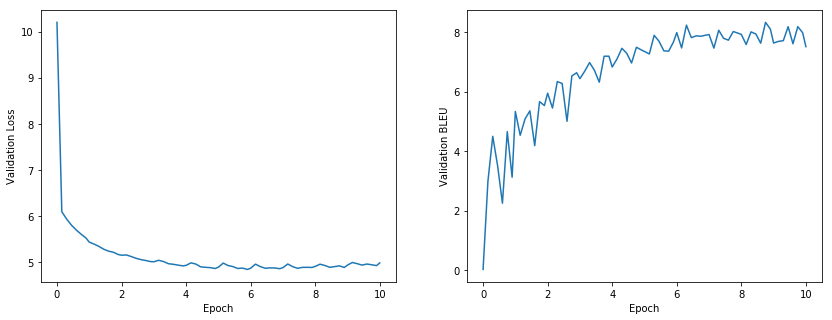

In [10]:
plot_single_learning_curve(experiment_results[0]['results'])

In [23]:
summarize_results(experiment_results)[['model_name', 'best_val_loss', 'best_val_bleu', 'runtime', 
                                       'total_params', 'trainable_params', 'dt_created']].head(1)

,model_name,best_val_loss,best_val_bleu,runtime,total_params,trainable_params,dt_created
0,zh-rnn-additive-attn-2018-12-14 02:14:28,4.846652,8.334325,578.66527,71591344,53591344,2018-12-14 11:53:32


In [24]:
# reload model 
MODEL_NAME_TO_RELOAD = 'zh-rnn-additive-attn-2018-12-14 02:14:28'
checkpoint = torch.load('model_checkpoints/{}.pth.tar'.format(MODEL_NAME_TO_RELOAD), map_location=device)
model.load_state_dict(checkpoint)

In [25]:
# check performance on validation set 
val_loss, val_bleu, val_hyp_idxs, val_ref_idxs, val_source_idxs, val_hyp_tokens, val_ref_tokens, val_source_tokens,\
val_attn = evaluate(model=model, loader=loaders_full['dev'], 
                    src_id2token=vocab[SRC_LANG]['id2token'], targ_id2token=vocab[TARG_LANG]['id2token'])
print("Validation BLEU: {:.2f} | Validation Loss: {:.2f}".format(val_bleu, val_loss))

Validation BLEU: 8.33 | Validation Loss: 4.92


In [26]:
# evaluate on test set 
test_loss, test_bleu, test_hyp_idxs, test_ref_idxs, test_source_idxs, test_hyp_tokens, test_ref_tokens, test_source_tokens,\
test_attn = evaluate(model=model, loader=loaders_full['test'], 
                     src_id2token=vocab[SRC_LANG]['id2token'], targ_id2token=vocab[TARG_LANG]['id2token'])
print("Test BLEU: {:.2f} | Test Loss: {:.2f}".format(test_bleu, test_loss))

Test BLEU: 9.45 | Test Loss: 4.79
